In [7]:
import numpy as np
import tensorflow as tf
import gpflow
import invgp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as rnd
from invgp.models import sample_SVGP
from gpflow.models import SVGP
import sys
sys.path.append('../')
from tests import utils
%load_ext autoreload
%autoreload 2

In [8]:
np.random.seed(0)

__Generate 200 datapoints__

In [9]:
X = np.random.uniform(0, 6, 200)[:, None]
Y = np.sin(2 * X) + 0.1 * np.cos(7 * X) + np.random.randn(*X.shape) * 0.1
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(50)
train_iter = iter(train_dataset.repeat())

__Initialize SVGP models__

In [10]:
nr_inducing_points = 50
inducing_variables = X[rnd.permutation(len(X))[:nr_inducing_points], :]
kernel = gpflow.kernels.SquaredExponential()
likelihood = gpflow.likelihoods.Gaussian()

SVGP_model = SVGP(kernel, likelihood,
                            inducing_variable=inducing_variables,
                            num_data=200)
sample_SVGP_model = sample_SVGP.sample_SVGP(kernel, likelihood,
                             inducing_variable=inducing_variables,
                             num_data=200)
matheron_sample_SVGP_model = sample_SVGP.sample_SVGP(kernel, likelihood,
                             inducing_variable=inducing_variables,
                             num_data=200,
                             matheron_sampler=True)

In [12]:
print('Untrained model elbos are: \n SVGP %s,  \n sample_SVGP %s,  \n Matheron sample SVGP %s'  
      %(SVGP_model.elbo((X, Y)).numpy(), sample_SVGP_model.elbo((X, Y)).numpy(), matheron_sample_SVGP_model.elbo((X, Y)).numpy()))

Untrained model elbos are: 
 SVGP -341.420979358352,  
 sample_SVGP -335.134904368966,  
 Matheron sample SVGP -363.02756452291953


__Define and run the optimiziation loop for SVGP model__

In [13]:
training_loss = SVGP_model.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam()
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGP_model.trainable_variables)
for step in range(3500):
    optimization_step()
    minibatch_elbo = -training_loss().numpy()
    print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))

Step: 0, Mini batch elbo: -343.8702866706517
Step: 1, Mini batch elbo: -333.69979589515435
Step: 2, Mini batch elbo: -347.24262214984077
Step: 3, Mini batch elbo: -337.52578003720816
Step: 4, Mini batch elbo: -337.3748583665879
Step: 5, Mini batch elbo: -333.9122609432228
Step: 6, Mini batch elbo: -336.8203917092202
Step: 7, Mini batch elbo: -337.8685357327143
Step: 8, Mini batch elbo: -338.6833345601845
Step: 9, Mini batch elbo: -340.67453804064553
Step: 10, Mini batch elbo: -337.2427900728288
Step: 11, Mini batch elbo: -325.77146938717885
Step: 12, Mini batch elbo: -327.8012150596956
Step: 13, Mini batch elbo: -332.29919119159996
Step: 14, Mini batch elbo: -329.47265772988743
Step: 15, Mini batch elbo: -336.586810787453
Step: 16, Mini batch elbo: -330.80119763829924
Step: 17, Mini batch elbo: -328.05776138810853
Step: 18, Mini batch elbo: -329.59946549896733
Step: 19, Mini batch elbo: -334.98108529316437
Step: 20, Mini batch elbo: -328.58113210179647
Step: 21, Mini batch elbo: -331.8

Step: 232, Mini batch elbo: -256.02780231672
Step: 233, Mini batch elbo: -258.3697506724775
Step: 234, Mini batch elbo: -250.75490213742563
Step: 235, Mini batch elbo: -259.9517496295093
Step: 236, Mini batch elbo: -261.759877479548
Step: 237, Mini batch elbo: -256.5985832812177
Step: 238, Mini batch elbo: -256.44257304682776
Step: 239, Mini batch elbo: -260.881335053021
Step: 240, Mini batch elbo: -256.48410299142233
Step: 241, Mini batch elbo: -256.7554325036788
Step: 242, Mini batch elbo: -262.2768588410224
Step: 243, Mini batch elbo: -255.80677589693244
Step: 244, Mini batch elbo: -256.5817721948973
Step: 245, Mini batch elbo: -252.80932793723392
Step: 246, Mini batch elbo: -264.21061799995846
Step: 247, Mini batch elbo: -252.98899715247998
Step: 248, Mini batch elbo: -249.81624414046874
Step: 249, Mini batch elbo: -256.75912049186087
Step: 250, Mini batch elbo: -265.01350141519305
Step: 251, Mini batch elbo: -256.1450029493231
Step: 252, Mini batch elbo: -263.22325627150167
Step: 

Step: 463, Mini batch elbo: -207.1320778172558
Step: 464, Mini batch elbo: -200.54442919136167
Step: 465, Mini batch elbo: -205.01705423462502
Step: 466, Mini batch elbo: -201.44353485366216
Step: 467, Mini batch elbo: -212.2667976379499
Step: 468, Mini batch elbo: -205.1224507824594
Step: 469, Mini batch elbo: -205.68906193457406
Step: 470, Mini batch elbo: -203.71914847406455
Step: 471, Mini batch elbo: -200.83541078877823
Step: 472, Mini batch elbo: -200.73577966460667
Step: 473, Mini batch elbo: -202.6383779410783
Step: 474, Mini batch elbo: -205.63253324561103
Step: 475, Mini batch elbo: -203.91917334000564
Step: 476, Mini batch elbo: -205.03992724245023
Step: 477, Mini batch elbo: -200.35371570871064
Step: 478, Mini batch elbo: -204.11700908203395
Step: 479, Mini batch elbo: -200.88394961207746
Step: 480, Mini batch elbo: -196.784393750072
Step: 481, Mini batch elbo: -204.0508369942437
Step: 482, Mini batch elbo: -201.45568849010354
Step: 483, Mini batch elbo: -205.62291006326728

Step: 697, Mini batch elbo: -167.6411301766742
Step: 698, Mini batch elbo: -166.0793809605888
Step: 699, Mini batch elbo: -169.05323176657885
Step: 700, Mini batch elbo: -168.92346739588285
Step: 701, Mini batch elbo: -166.9797441193773
Step: 702, Mini batch elbo: -167.0217428558666
Step: 703, Mini batch elbo: -169.97735499253258
Step: 704, Mini batch elbo: -164.08686169447532
Step: 705, Mini batch elbo: -165.37085647505057
Step: 706, Mini batch elbo: -168.46054256651664
Step: 707, Mini batch elbo: -165.86883597964606
Step: 708, Mini batch elbo: -167.87178420878217
Step: 709, Mini batch elbo: -161.70580660574282
Step: 710, Mini batch elbo: -165.4755595195733
Step: 711, Mini batch elbo: -165.38012432592282
Step: 712, Mini batch elbo: -168.8955912898459
Step: 713, Mini batch elbo: -164.14886685496936
Step: 714, Mini batch elbo: -162.7207624997134
Step: 715, Mini batch elbo: -165.84322012321695
Step: 716, Mini batch elbo: -168.3525911575663
Step: 717, Mini batch elbo: -164.84174083404483


Step: 932, Mini batch elbo: -136.94778859191672
Step: 933, Mini batch elbo: -139.14359416925814
Step: 934, Mini batch elbo: -137.8082966127217
Step: 935, Mini batch elbo: -140.75060913891238
Step: 936, Mini batch elbo: -139.2999449431333
Step: 937, Mini batch elbo: -137.45208621303485
Step: 938, Mini batch elbo: -139.48630454154141
Step: 939, Mini batch elbo: -136.80007393183465
Step: 940, Mini batch elbo: -137.73382260316603
Step: 941, Mini batch elbo: -140.30586714740866
Step: 942, Mini batch elbo: -136.75051390436042
Step: 943, Mini batch elbo: -135.2855301257301
Step: 944, Mini batch elbo: -138.82070157742015
Step: 945, Mini batch elbo: -137.45439678956367
Step: 946, Mini batch elbo: -135.69604239562165
Step: 947, Mini batch elbo: -139.83592596702334
Step: 948, Mini batch elbo: -136.5465644347234
Step: 949, Mini batch elbo: -135.4780614529089
Step: 950, Mini batch elbo: -136.96702052674925
Step: 951, Mini batch elbo: -135.5800004824799
Step: 952, Mini batch elbo: -135.264421758214


Step: 1166, Mini batch elbo: -111.89647770127883
Step: 1167, Mini batch elbo: -111.60563839233825
Step: 1168, Mini batch elbo: -112.19798117377253
Step: 1169, Mini batch elbo: -111.06255005499197
Step: 1170, Mini batch elbo: -113.17468240859822
Step: 1171, Mini batch elbo: -109.35432660214494
Step: 1172, Mini batch elbo: -110.78364922081262
Step: 1173, Mini batch elbo: -111.2547939785857
Step: 1174, Mini batch elbo: -111.14902093346925
Step: 1175, Mini batch elbo: -111.2086116794464
Step: 1176, Mini batch elbo: -111.14185325065525
Step: 1177, Mini batch elbo: -112.29732557003358
Step: 1178, Mini batch elbo: -110.91164782488248
Step: 1179, Mini batch elbo: -110.60689423566369
Step: 1180, Mini batch elbo: -109.85001387504592
Step: 1181, Mini batch elbo: -110.52854095212795
Step: 1182, Mini batch elbo: -110.55561679008724
Step: 1183, Mini batch elbo: -110.1472188789738
Step: 1184, Mini batch elbo: -109.34678276756955
Step: 1185, Mini batch elbo: -109.5266172250184
Step: 1186, Mini batch e

Step: 1401, Mini batch elbo: -86.06696947966884
Step: 1402, Mini batch elbo: -86.91639299189879
Step: 1403, Mini batch elbo: -87.96628998168768
Step: 1404, Mini batch elbo: -86.18310497255688
Step: 1405, Mini batch elbo: -87.04562423019686
Step: 1406, Mini batch elbo: -86.99139639041047
Step: 1407, Mini batch elbo: -86.89325930058017
Step: 1408, Mini batch elbo: -88.13303090611127
Step: 1409, Mini batch elbo: -85.28817418732774
Step: 1410, Mini batch elbo: -86.21561704605666
Step: 1411, Mini batch elbo: -87.12516721452882
Step: 1412, Mini batch elbo: -86.64748545407963
Step: 1413, Mini batch elbo: -85.11250122872217
Step: 1414, Mini batch elbo: -86.0293580057199
Step: 1415, Mini batch elbo: -84.44538757463606
Step: 1416, Mini batch elbo: -85.76121240670217
Step: 1417, Mini batch elbo: -85.09810433738362
Step: 1418, Mini batch elbo: -86.1409536892583
Step: 1419, Mini batch elbo: -83.46866442726369
Step: 1420, Mini batch elbo: -85.14079153816095
Step: 1421, Mini batch elbo: -85.738917667

Step: 1637, Mini batch elbo: -61.560822852517205
Step: 1638, Mini batch elbo: -64.1269765814468
Step: 1639, Mini batch elbo: -62.31450901565536
Step: 1640, Mini batch elbo: -63.28020648009749
Step: 1641, Mini batch elbo: -60.70837279498093
Step: 1642, Mini batch elbo: -62.856148729218845
Step: 1643, Mini batch elbo: -64.86819661803875
Step: 1644, Mini batch elbo: -62.39345300561975
Step: 1645, Mini batch elbo: -64.70247594360845
Step: 1646, Mini batch elbo: -63.212794222251176
Step: 1647, Mini batch elbo: -61.150070543642265
Step: 1648, Mini batch elbo: -61.30448564613293
Step: 1649, Mini batch elbo: -65.4800426367482
Step: 1650, Mini batch elbo: -64.84649936147592
Step: 1651, Mini batch elbo: -61.91391809997793
Step: 1652, Mini batch elbo: -61.96658549710938
Step: 1653, Mini batch elbo: -61.7967783766755
Step: 1654, Mini batch elbo: -62.22497250550126
Step: 1655, Mini batch elbo: -60.37491833620162
Step: 1656, Mini batch elbo: -61.88472990413433
Step: 1657, Mini batch elbo: -60.972195

Step: 1876, Mini batch elbo: -41.37243495977398
Step: 1877, Mini batch elbo: -38.440488018968665
Step: 1878, Mini batch elbo: -39.477642918216276
Step: 1879, Mini batch elbo: -40.294600422909554
Step: 1880, Mini batch elbo: -41.0091435395306
Step: 1881, Mini batch elbo: -39.31048806049943
Step: 1882, Mini batch elbo: -40.61003989483011
Step: 1883, Mini batch elbo: -39.14558452296065
Step: 1884, Mini batch elbo: -39.325838151380985
Step: 1885, Mini batch elbo: -39.83116435330423
Step: 1886, Mini batch elbo: -38.56331580880904
Step: 1887, Mini batch elbo: -41.32268802217553
Step: 1888, Mini batch elbo: -41.15166263340832
Step: 1889, Mini batch elbo: -40.92277869648994
Step: 1890, Mini batch elbo: -39.97643352222415
Step: 1891, Mini batch elbo: -39.584936811438965
Step: 1892, Mini batch elbo: -36.00677680926134
Step: 1893, Mini batch elbo: -41.18859261655547
Step: 1894, Mini batch elbo: -39.560435250360996
Step: 1895, Mini batch elbo: -39.34807702001454
Step: 1896, Mini batch elbo: -38.82

Step: 2113, Mini batch elbo: -19.481470449973237
Step: 2114, Mini batch elbo: -19.354872000545434
Step: 2115, Mini batch elbo: -17.95890502096557
Step: 2116, Mini batch elbo: -16.69750155391406
Step: 2117, Mini batch elbo: -19.663517524095994
Step: 2118, Mini batch elbo: -17.231578822824154
Step: 2119, Mini batch elbo: -15.958811421406365
Step: 2120, Mini batch elbo: -19.957354210315877
Step: 2121, Mini batch elbo: -16.941909603713782
Step: 2122, Mini batch elbo: -17.354519799407
Step: 2123, Mini batch elbo: -20.586054449547706
Step: 2124, Mini batch elbo: -19.084556974863112
Step: 2125, Mini batch elbo: -17.72198656447654
Step: 2126, Mini batch elbo: -16.606106708646188
Step: 2127, Mini batch elbo: -21.97649779938736
Step: 2128, Mini batch elbo: -16.324501456474042
Step: 2129, Mini batch elbo: -15.756404954826893
Step: 2130, Mini batch elbo: -14.05629668810391
Step: 2131, Mini batch elbo: -19.461375258871087
Step: 2132, Mini batch elbo: -17.695158736364167
Step: 2133, Mini batch elbo:

Step: 2352, Mini batch elbo: -1.2518177717943715
Step: 2353, Mini batch elbo: 1.9296547815056861
Step: 2354, Mini batch elbo: 2.240827544442908
Step: 2355, Mini batch elbo: 1.0746166691482024
Step: 2356, Mini batch elbo: 0.05841399511081491
Step: 2357, Mini batch elbo: 3.8256045748548395
Step: 2358, Mini batch elbo: 0.4548291591757341
Step: 2359, Mini batch elbo: 1.993229828830522
Step: 2360, Mini batch elbo: 4.056660332876927
Step: 2361, Mini batch elbo: 1.9784049135609436
Step: 2362, Mini batch elbo: 3.794169518317446
Step: 2363, Mini batch elbo: 4.232309752198137
Step: 2364, Mini batch elbo: 5.179716350863657
Step: 2365, Mini batch elbo: 5.433279415607181
Step: 2366, Mini batch elbo: 5.0907801974208375
Step: 2367, Mini batch elbo: 2.28069481375951
Step: 2368, Mini batch elbo: 5.140400048073314
Step: 2369, Mini batch elbo: 0.7195338364449668
Step: 2370, Mini batch elbo: 4.748443942559188
Step: 2371, Mini batch elbo: 5.385339056485517
Step: 2372, Mini batch elbo: 3.092216272141414
Ste

Step: 2592, Mini batch elbo: 19.768271678499215
Step: 2593, Mini batch elbo: 18.291018037827687
Step: 2594, Mini batch elbo: 17.9624652597995
Step: 2595, Mini batch elbo: 19.605996684422905
Step: 2596, Mini batch elbo: 22.933752126515778
Step: 2597, Mini batch elbo: 20.60414113268494
Step: 2598, Mini batch elbo: 22.424231187596167
Step: 2599, Mini batch elbo: 25.499502463398105
Step: 2600, Mini batch elbo: 22.693353030508487
Step: 2601, Mini batch elbo: 22.071668027544764
Step: 2602, Mini batch elbo: 23.058254851033734
Step: 2603, Mini batch elbo: 26.251332905409186
Step: 2604, Mini batch elbo: 21.273582629139163
Step: 2605, Mini batch elbo: 20.1302044572747
Step: 2606, Mini batch elbo: 20.534750272769
Step: 2607, Mini batch elbo: 22.50832566163212
Step: 2608, Mini batch elbo: 22.153161912478694
Step: 2609, Mini batch elbo: 22.034769375132953
Step: 2610, Mini batch elbo: 21.169154455826146
Step: 2611, Mini batch elbo: 24.011008508542744
Step: 2612, Mini batch elbo: 21.28367889514712
St

Step: 2831, Mini batch elbo: 36.82656305207792
Step: 2832, Mini batch elbo: 42.772920545296344
Step: 2833, Mini batch elbo: 35.46419337102951
Step: 2834, Mini batch elbo: 41.428232092917725
Step: 2835, Mini batch elbo: 35.19283273512084
Step: 2836, Mini batch elbo: 40.469042455794884
Step: 2837, Mini batch elbo: 38.70059868263349
Step: 2838, Mini batch elbo: 39.269270099521215
Step: 2839, Mini batch elbo: 46.716422063121385
Step: 2840, Mini batch elbo: 41.663476483144755
Step: 2841, Mini batch elbo: 38.19756201900839
Step: 2842, Mini batch elbo: 41.39195078020157
Step: 2843, Mini batch elbo: 35.55729644944793
Step: 2844, Mini batch elbo: 40.075199140584346
Step: 2845, Mini batch elbo: 42.200676442559846
Step: 2846, Mini batch elbo: 45.26254541565045
Step: 2847, Mini batch elbo: 41.85702628069754
Step: 2848, Mini batch elbo: 42.29636243837423
Step: 2849, Mini batch elbo: 37.06639568086953
Step: 2850, Mini batch elbo: 38.172999331294044
Step: 2851, Mini batch elbo: 35.38239074929291
Step

Step: 3070, Mini batch elbo: 56.724218789048784
Step: 3071, Mini batch elbo: 48.559407252357104
Step: 3072, Mini batch elbo: 54.356417847698204
Step: 3073, Mini batch elbo: 50.63891791742661
Step: 3074, Mini batch elbo: 52.654277290308784
Step: 3075, Mini batch elbo: 62.99258428049258
Step: 3076, Mini batch elbo: 52.25477210233461
Step: 3077, Mini batch elbo: 58.966048486976945
Step: 3078, Mini batch elbo: 61.717742487601164
Step: 3079, Mini batch elbo: 58.10318879254291
Step: 3080, Mini batch elbo: 55.353921261702
Step: 3081, Mini batch elbo: 58.468403754866266
Step: 3082, Mini batch elbo: 58.98761090135005
Step: 3083, Mini batch elbo: 53.090337614102594
Step: 3084, Mini batch elbo: 52.96683013487787
Step: 3085, Mini batch elbo: 62.29239500444305
Step: 3086, Mini batch elbo: 56.189140302198595
Step: 3087, Mini batch elbo: 53.718153351803494
Step: 3088, Mini batch elbo: 57.03708337048053
Step: 3089, Mini batch elbo: 58.534006825762376
Step: 3090, Mini batch elbo: 61.92839396623157
Step

Step: 3309, Mini batch elbo: 67.34537157278444
Step: 3310, Mini batch elbo: 64.97540838743731
Step: 3311, Mini batch elbo: 71.90974796471686
Step: 3312, Mini batch elbo: 66.60781137542965
Step: 3313, Mini batch elbo: 77.91500856089411
Step: 3314, Mini batch elbo: 74.11451537011908
Step: 3315, Mini batch elbo: 64.83456957685911
Step: 3316, Mini batch elbo: 75.44973689219242
Step: 3317, Mini batch elbo: 68.36157269566928
Step: 3318, Mini batch elbo: 76.48020396224862
Step: 3319, Mini batch elbo: 70.056572054566
Step: 3320, Mini batch elbo: 68.0538668856901
Step: 3321, Mini batch elbo: 75.00222314883781
Step: 3322, Mini batch elbo: 73.1104136878217
Step: 3323, Mini batch elbo: 72.58078834197484
Step: 3324, Mini batch elbo: 71.39505433116109
Step: 3325, Mini batch elbo: 71.00982984619682
Step: 3326, Mini batch elbo: 68.27316596191713
Step: 3327, Mini batch elbo: 68.45219915340968
Step: 3328, Mini batch elbo: 70.39423877506303
Step: 3329, Mini batch elbo: 78.98725191645255
Step: 3330, Mini 

__Initialize sample SVGP models with fitted parameters from "regular" SVGP__

In [15]:
utils.initialize_with_trained_params(sample_SVGP_model, SVGP_model)
utils.initialize_with_trained_params(matheron_sample_SVGP_model, SVGP_model)

__Visualize data and fitted model__

Running sample_SVGP.predict_f_samples.
Running sample_SVGP.predict_f_samples.


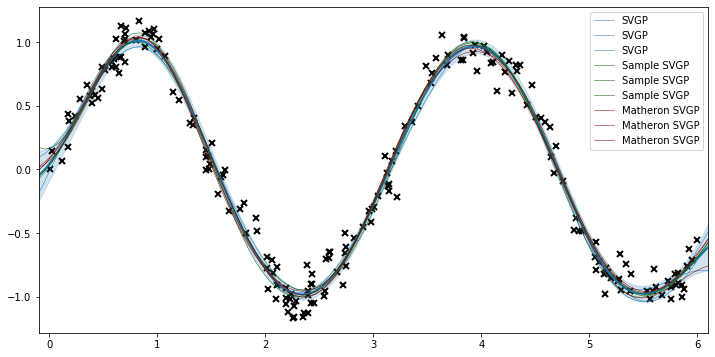

In [17]:
# test points
xx = np.linspace(-0.1, 6.1, 100).reshape(100, 1)
# predict mean and variance of latent GP at test points
mean, var = SVGP_model.predict_f(xx)
# generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
SVGP_samples = SVGP_model.predict_f_samples(xx, 3)  
sample_SVGP_samples = sample_SVGP_model.predict_f_samples(xx, 3)  
matheron_SVGP_samples = matheron_sample_SVGP_model.predict_f_samples(xx, 3)

# plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,)
plt.plot(xx, SVGP_samples[:, :, 0].numpy().T, "C0", linewidth=0.5, label='SVGP')
plt.plot(xx, sample_SVGP_samples[:, :, 0].numpy().T, "C0", linewidth=0.5, c='darkgreen', label='Sample SVGP')
plt.plot(xx, matheron_SVGP_samples[:, :, 0].numpy().T, "C0", linewidth=0.5, c='darkred', label='Matheron SVGP')
plt.legend()
_ = plt.xlim(-0.1, 6.1)
plt.show()

In [22]:
#compare elbos
SVGP_model_elbo = SVGP_model.elbo((X, Y))
print('SVGP model elbo is:', SVGP_model_elbo.numpy())

sample_SVGP_model_elbos = [sample_SVGP_model.elbo((X, Y)).numpy() for _ in range(10)]
expected_sample_elbo = np.mean(sample_SVGP_model_elbos)
var_sample_elbo = np.var(sample_SVGP_model_elbos)
print('Expectation and variance of the sample ELBO estimator:', expected_sample_elbo, var_sample_elbo)
np.testing.assert_allclose(SVGP_model_elbo, expected_sample_elbo, rtol=0.05, atol=0.0) 

matheron_sample_SVGP_model_elbos = [matheron_sample_SVGP_model.elbo((X, Y)).numpy() for _ in range(10)]
expected_matheron_sample_elbo = np.mean(matheron_sample_SVGP_model_elbos)
var_matheron_sample_elbo = np.var(matheron_sample_SVGP_model_elbos)
print('Expectation and variance of the Matheron sample ELBO estimator:', expected_matheron_sample_elbo, var_matheron_sample_elbo)

SVGP model elbo is: 81.46792968019535
Expectation and variance of the sample ELBO estimator: 80.91021882945746 2.00167764692914
Expectation and variance of the Matheron sample ELBO estimator: 80.81668765347857 2.1201504138748133
